JSD Train-Validation (Before): 0.0
JSD Train-Test (Before): 0.001
JSD Validation-Test (Before): 0.001
JSD Train-Validation (After): 0.0
JSD Train-Test (After): 0.001
JSD Validation-Test (After): 0.001


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

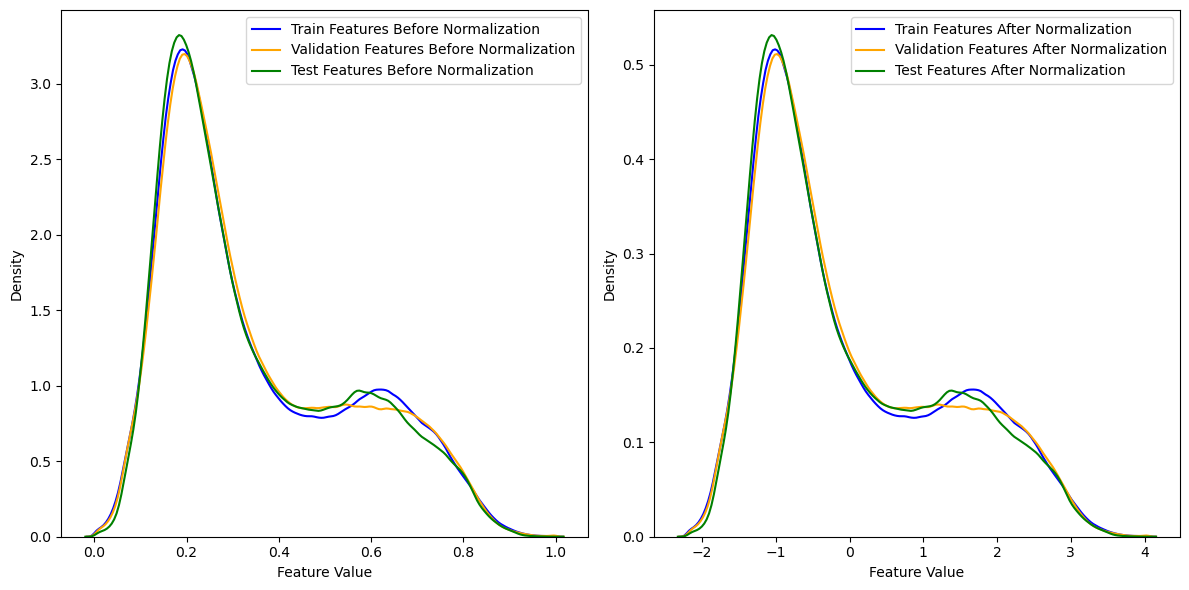

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import scipy.stats
import seaborn as sns

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

current_directory = os.getcwd()

# Directories
train_data_dir = os.path.normpath(os.path.join(current_directory,'Dataset_3', 'train'))
train_data_dir = os.path.normpath(os.path.join(current_directory,'Dataset_3', 'val'))
train_data_dir = os.path.normpath(os.path.join(current_directory,'Dataset_3', 'test'))

# Calculate mean and std of every 10th sample of the original training dataset on the GPU
n = 1  # set n to the desired subsampling factor
mean_list = []
std_list = []
to_tensor = transforms.ToTensor()

original_train_dataset = datasets.ImageFolder(train_data_dir)
for i, (data, target) in enumerate(original_train_dataset):
    if i % n == 0:
        data = to_tensor(data).unsqueeze(0)  # Convert to tensor and add an extra dimension for batch size
        data = data.to(device)
        mean_list.append(torch.mean(data, dim=(0, 2, 3)))
        std_list.append(torch.std(data, dim=(0, 2, 3)))

# Calculate the overall mean and std
mean = torch.mean(torch.stack(mean_list), dim=0)
std = torch.mean(torch.stack(std_list), dim=0)

# Move the mean and std tensors back to the CPU for printing
mean = mean.cpu().tolist()
std = std.cpu().tolist()

# Define the normalization transformation
normalize = transforms.Normalize(mean=mean, std=std)

# Define transform to apply on the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True)
])

# Load datasets without normalization
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

# Function to extract features from the dataset
def extract_features(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    feature_list = []

    for data, _ in loader:
        data = data.to(device)
        feature_list.append(data.cpu().numpy())

    features = np.concatenate(feature_list, axis=0)
    features = features.reshape(features.shape[0], -1)  # Flatten features
    return features

# Extract features for train, val, and test sets before normalization
train_features_before = extract_features(train_dataset)
val_features_before = extract_features(val_dataset)
test_features_before = extract_features(test_dataset)

# Apply normalization to the datasets
train_dataset_norm = datasets.ImageFolder(train_data_dir, transform=transforms.Compose([transform, normalize]))
val_dataset_norm = datasets.ImageFolder(val_data_dir, transform=transforms.Compose([transform, normalize]))
test_dataset_norm = datasets.ImageFolder(test_data_dir, transform=transforms.Compose([transform, normalize]))

# Extract features for train, val, and test sets after normalization
train_features_after = extract_features(train_dataset_norm)
val_features_after = extract_features(val_dataset_norm)
test_features_after = extract_features(test_dataset_norm)

# Function to compute probability distribution from histogram
def compute_distribution(hist, num_bins):
    bins_centers = np.linspace(np.min(hist), np.max(hist), num_bins)
    return hist / np.sum(hist), bins_centers

# Function to compute Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    # Compute the average of the two distributions
    m = 0.5 * (p + q)
    # Compute Jensen-Shannon Divergence using entropy
    jsd = 0.5 * (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m))
    return jsd

# Compute histograms for features before and after normalization
train_hist_before, _ = np.histogram(train_features_before.flatten(), bins=50, density=True)
val_hist_before, _ = np.histogram(val_features_before.flatten(), bins=50, density=True)
test_hist_before, _ = np.histogram(test_features_before.flatten(), bins=50, density=True)

train_hist_after, _ = np.histogram(train_features_after.flatten(), bins=50, density=True)
val_hist_after, _ = np.histogram(val_features_after.flatten(), bins=50, density=True)
test_hist_after, _ = np.histogram(test_features_after.flatten(), bins=50, density=True)


# Compute probability distributions
train_dist_before, _ = compute_distribution(train_hist_before, 50)
val_dist_before, _ = compute_distribution(val_hist_before, 50)
test_dist_before, _ = compute_distribution(test_hist_before, 50)

train_dist_after, _ = compute_distribution(train_hist_after, 50)
val_dist_after, _ = compute_distribution(val_hist_after, 50)
test_dist_after, _ = compute_distribution(test_hist_after, 50)

# Compute Jensen-Shannon Divergence between train-validation, validation-test, and train-test distributions before and after normalization
jsd_train_val_before = jensen_shannon_divergence(train_dist_before, val_dist_before)
jsd_train_test_before = jensen_shannon_divergence(train_dist_before, test_dist_before)
jsd_val_test_before = jensen_shannon_divergence(val_dist_before, test_dist_before)

jsd_train_val_after = jensen_shannon_divergence(train_dist_after, val_dist_after)
jsd_train_test_after = jensen_shannon_divergence(train_dist_after, test_dist_after)
jsd_val_test_after = jensen_shannon_divergence(val_dist_after, test_dist_after)

# Print Jensen-Shannon Divergence values
print("JSD Train-Validation (Before):", round(jsd_train_val_before, 3))
print("JSD Train-Test (Before):", round(jsd_train_test_before, 3))
print("JSD Validation-Test (Before):", round(jsd_val_test_before, 3))
print("JSD Train-Validation (After):", round(jsd_train_val_after, 3))
print("JSD Train-Test (After):", round(jsd_train_test_after, 3))
print("JSD Validation-Test (After):", round(jsd_val_test_after, 3))

# Function to plot probability density curves for features
def plot_density(features, title, color):
    sns.kdeplot(features.flatten(), color=color, label=title)
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
  

# Plot density curves
plt.figure(figsize=(12, 6))

# Plot before normalization
plt.subplot(1, 2, 1)
plot_density(train_features_before, 'Train Features Before Normalization', 'blue')
plot_density(val_features_before, 'Validation Features Before Normalization', 'orange')
plot_density(test_features_before, 'Test Features Before Normalization', 'green')
plt.legend()

# Plot after normalization
plt.subplot(1, 2, 2)
plot_density(train_features_after, 'Train Features After Normalization', 'blue')
plot_density(val_features_after, 'Validation Features After Normalization', 'orange')
plot_density(test_features_after, 'Test Features After Normalization', 'green')
plt.legend()

plt.tight_layout()
plt.savefig('Dat3_pdf.jpg')
plt.show()
